In [1]:
# import context manager: SparkSession
from pyspark.sql import SparkSession
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql import SQLContext
# set up the session

spark = SparkSession \
    .builder \
    .master("local") \
    .appName("Ed Squad Project") \
    .config("spark.executor.memory", '32g') \
    .config('spark.executor.cores', '6') \
    .config('spark.cores.max', '6')\
    .config("spark.driver.memory",'32g') \
    .getOrCreate()

sc = spark.sparkContext
        
        
sqlContext = SQLContext(spark)

In [2]:
spark.conf.get("spark.sql.shuffle.partitions")

'200'

In [3]:
import os
os.listdir()
os.getcwd()

'/sfs/qumulo/qhome/smn7ba/ds5110/project'

In [4]:
#import pandas too for visualizations
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix
pd.set_option('display.max_rows', 200000)

In [5]:
%%time
#import mlLib libraries for classification
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder,TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.feature import PCA
from pyspark.mllib.evaluation import MulticlassMetrics,BinaryClassificationMetrics
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

CPU times: user 3.31 ms, sys: 2.31 ms, total: 5.62 ms
Wall time: 4.89 ms


### About data
AMERICAN COMMUNITY SURVEY 2015-2019 5-YEAR SAMPLE <br>
5-in-100 national random sample of the population <br>
Contains all households and persons from the 1% ACS samples for 2015, 2016, 2017, 2018, and 2019 identifiable by year. <br>
The data include persons in group quarters. <br>
This is a weighted sample. <br>
The smallest identifiable geographic unit is the PUMA, containing at least 100,000 persons. PUMAs do not cross state boundaries. <br>
Users should read the FAQ on the multi-year data. <br>


WHERE CAN I GET BETTER GEOGRAPHIC IDENTIFIERS? <br>
The lowest unit of geography in the microdata files is still the PUMA. PUMAs contain at least 100,000 people. <br>
Aggregate data (but not microdata) is currently available from the Census Bureau for geographic areas as small as block groups, but only for the entire 2005-2009 period. <br>


PERNUM numbers all persons within each household consecutively in the order in which they appear on the original census or survey form. <br>
When combined with SAMPLE and SERIAL, PERNUM uniquely identifies each person within the IPUMS. <br>

MULTYEAR identifies the actual year of survey in multi-year ACS/PRCS samples. <br>

<br>
For example, the 3-year ACS and PRCS data files each include cases from three single-year files. <br>
For these multi-year samples, the YEAR variable identifies the last year of data (2007 for the 2005-2007 3-year data; 2008 for the 2006-2008 data; and so on). <br>
MULTYEAR gives the single-year sample from which the case was drawn (2005, 2006, or 2007 for the 2005-2007 3-year data; 2006, 2007, or 2008 for the 2006-2008 3-year data; and so on). <br>

https://usa.ipums.org/usa/acs_multyr.shtml


### Read Data; Create a binary flag; rename columns; Drop if necessary

In [6]:
%%time
#import whole data from the census
data = spark.read.csv('/project/ds5559/ds5110_project_snoo/acs_15_19_south.csv', inferSchema="true", header="true")

CPU times: user 17 ms, sys: 9.88 ms, total: 26.9 ms
Wall time: 2min 9s


In [7]:
%%time
#writing a user defined function to create a Educated or Not Flag - if EDUC>6 then it is 1 and if not 0
#https://towardsdatascience.com/5-ways-to-add-a-new-column-in-a-pyspark-dataframe-4e75c2fd8c08
def EDUCFunc(value):
  if   value > 6: 
      return 1
  else:
      return 0

#create the function to be applied and create a new column EDUC_FLAG
udfsomefunc = F.udf(EDUCFunc, IntegerType())
data = data.withColumn("EDUC_FLAG", udfsomefunc("EDUC"))
#see sample data
data.select('EDUC_FLAG').show(5)

+---------+
|EDUC_FLAG|
+---------+
|        0|
|        1|
|        0|
|        1|
|        0|
+---------+
only showing top 5 rows

CPU times: user 6.14 ms, sys: 2.62 ms, total: 8.76 ms
Wall time: 1.04 s


In [8]:
%%time
#check the count for EDUC>6 or verify if flag was populated correctly
data.filter(data.EDUC>6).count()

CPU times: user 4.82 ms, sys: 2.73 ms, total: 7.56 ms
Wall time: 31 s


2470127

In [9]:
%%time
#Verify the flag count. Should match number above
data.filter(data.EDUC_FLAG!=0).count()

CPU times: user 5.14 ms, sys: 3.05 ms, total: 8.19 ms
Wall time: 33.1 s


2470127

In [10]:
%%time
#renaming dependent variable to label because the classfier is not recognizing other names. Skip thsi if you are trying other classifiers

df = data.withColumn("label",data.EDUC_FLAG) \
      .drop("EDUC_FLAG")

CPU times: user 1.96 ms, sys: 0 ns, total: 1.96 ms
Wall time: 45.7 ms


In [11]:
#saving col names in case if we can use it later ot iterate or use the list for labels etc.
#cols = df.columns
cols = df.drop('_c0','EDUC','CLUSTER','CBSERIAL','STRATA','HHWT','EDUCD',\
 'QCOSTELE',\
 'QCOSTFUE',\
 'QCOSTGAS',\
 'QCOSTWAT',\
 'QFOODSTM',\
 'QINSINCL',\
 'QMORTGAG',\
 'QOWNERSH',\
 'QPROPINS',\
 'QTAXINCL',\
 'QVALUEH',\
 'QFUELHEA',\
 'QCIDIAL',\
 'QCILAPTOP',\
 'QCINETHH',\
 'QCIOTHSVC',\
 'QCISAT',\
 'QCISMRTPHN',\
 'QCITABLET',\
 'QCIDATAPLN',\
 'QVEHICLE',\
 'QAGE',\
 'QMARRNO',\
 'QMARST',\
 'QRELATE',\
 'QSEX',\
 'QYRMARR',\
 'QBPL',\
 'QCITIZEN',\
 'QHISPAN',\
 'QRACE',\
 'QYRNATUR',\
 'QHINSEMP',\
 'QHINSPUR',\
 'QHINSTRI',\
 'QHINSCAI',\
 'QHINSCAR',\
 'QHINSVA',\
 'QHINSIHS',\
 'QEDUC',\
 'QGRADEAT',\
 'QDEGFIELD',\
 'QSCHOOL',\
 'QCLASSWK',\
 'QEMPSTAT',\
 'QIND',\
 'QOCC',\
 'QUHRSWOR',\
 'QINCEARN',\
 'QINCBUS',\
 'QINCINVS',\
 'QINCOTHE',\
 'QINCRETI',\
 'QINCSS',\
 'QINCSUPP',\
 'QINCTOT',\
 'QFTOTINC',\
 'QINCWAGE',\
 'QINCWELF',\
 'QVETSTAT',\
 'QCARPOOL',\
 'QDEPARTS',\
 'QPWSTAT2',\
 'QRIDERS',\
 'QTRANTIM',\
 'QTRANWOR',\
 'QGCHOUSE',\
 'QGCMONTH',\
 'QGCRESPO').columns
#spark.createDataFrame(cols,StringType()).toPandas()

In [12]:
len(cols)

132

In [13]:
#Define variables which will be consistently used
seed = 42
split_ratio = [0.7,0.3]
numFolds = 3
threads = 6

rf = RandomForestClassifier(labelCol = "label", featuresCol = "scaledFeatures_train")

paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [30, 50]).build()

pca_model = PCA(k=10, inputCol = "scaledFeatures_train", outputCol = "pca_features_cv")

#create a param grid to pass to cross validator 
#k --> number of principal components
#number of treess in rf
#need to add more later
paramGrid_pca = ParamGridBuilder().addGrid(rf.numTrees, [20, 30, 50]).build()

#.addGrid(pca_model.k, [10]) \ 
bcm = BinaryClassificationEvaluator()

selected_cols=[cols for cols in cols if cols not in['label','MULTYEAR']]
#Identified first 35 variables of interest
keep_35 = ["HHTYPE","REGION","STATEFIP","COUNTYFIP","METRO","COSTELEC","COSTGAS","COSTWATR","COSTFUEL","FOODSTMP","CINETHH","CILAPTOP",\
        "CISMRTPHN","CITABLET","VEHICLES","COUPLETYPE","NFAMS","NMOTHERS","NFATHERS","CITIZEN","YRSUSA1","RACAMIND","RACASIAN","RACBLK","RACPACIS"\
        ,"RACWHT","RACOTHER","HCOVANY","EMPSTAT","LABFORCE","CLASSWKR","UHRSWORK","VETSTAT","TRANWORK","GCHOUSE","label","MULTYEAR"]


### Reusable Functions to create sample data, split data, preprocess train, tst, fit model and generate classfication metrics and CM

In [14]:
def createSampleData(df,cols,sampleweight):
    df_small = df.select(cols)
    sampled = df_small.sampleBy("MULTYEAR", fractions={2015:sampleweight, 2016: sampleweight, 2017:sampleweight, 2018:sampleweight, 2019:sampleweight}, seed=seed)
    return sampled

def splitData(dataframe,split_ratio,seed):
    training_data, test_data = dataframe.randomSplit(split_ratio, seed=seed)
    cached_tr = training_data.cache()
    cached_test = test_data.cache()
    return cached_tr,cached_test

def preProcessTrainFit(cached_tr,model,pca_model,paramGrid,evaluator,numFolds,seed ):
    #Assemble traininngdata
    #pass all the features into vector assembler to create a vector format to pass to the classification model
    selected_cols=[cols for cols in cached_tr.columns if cols not in['label','MULTYEAR']]
    assembler = VectorAssembler(inputCols=selected_cols, outputCol="features") 
    #scale
    scaler_train = StandardScaler(inputCol="features", outputCol="scaledFeatures_train",withStd=False, withMean=True)

    #creating a pipeline with the assembler,scaler and model to use in the cross validator
    if pca_model is None:  print("Not PCA"); ppl_cv = Pipeline(stages = [assembler,scaler_train, model])
        
    else: 
        print("PCA");
        rf = RandomForestClassifier(labelCol = "label", featuresCol = "pca_features_cv")
        ppl_cv = Pipeline(stages = [assembler,scaler_train,pca_model, rf])

    #passs the model with variosu combinations of the parameters and it will pick the best one. Using 3 folds to save time. Check seed=42.
    crossval = CrossValidator(estimator = ppl_cv,\
                                            estimatorParamMaps=paramGrid,\
                                            evaluator = evaluator ,\
                                            numFolds= numFolds,seed=seed,parallelism=threads)
    #this is our best model - fit the training data
    #https://spark.apache.org/docs/2.3.0/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator
    return crossval.fit(cached_tr)
    

def preProcessTest(test_data):
    #prepare test data to test predictions
    selected_cols=[cols for cols in test_data.columns if cols not in['label','MULTYEAR']]
    assembler_test = VectorAssembler(inputCols=selected_cols, outputCol="features") 
    transformed_test = assembler_test.transform(test_data)
    #register table as sql table and keep only columns fo interest and save in a new dataframe. This can be done without using SQl as well.
    transformed_test.registerTempTable('transformed_tbl_test')
    transformed_df_test = sqlContext.sql('select label,features from transformed_tbl_test')
    #scale test data
    scaler_test = StandardScaler(inputCol="features", outputCol="scaledFeatures",withStd=False, withMean=True)
    scalerModel_test = scaler_test.fit(transformed_df_test)
    scaledData_test = scalerModel_test.transform(transformed_df_test)
    
    return scaledData_test

In [15]:
#https://runawayhorse001.github.io/LearningApacheSpark/classification.html
#https://shihaojran.com/distributed-machine-learning-using-pyspark/
#https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/
# Calculate the elements of the confusion matrix
#https://runawayhorse001.github.io/LearningApacheSpark/classification.html#random-forest-classification

def createLabelsCM(preds):
    
    ##saving labels in a list to pass to the plot
    class_temp = preds.select("label").groupBy("label")\
                            .count().sort('count', ascending=False).toPandas()
    class_temp = class_temp["label"].values.tolist()
    y_true = preds.select("label")
    y_true = y_true.toPandas()

    y_pred = preds.select("prediction")
    y_pred = y_pred.toPandas()

    return confusion_matrix(y_true, y_pred,class_temp)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def classificationMetrics(preds, evaluator):
    #calcualte classification report
    TN = preds.filter('prediction = 0 AND label = prediction').count()
    TP = preds.filter('prediction = 1 AND label = prediction').count()
    FN = preds.filter('prediction = 0 AND label <> prediction').count()
    FP = preds.filter('prediction = 1 AND label <> prediction').count()
    # show confusion matrix
    preds.groupBy('label', 'prediction').count().show()
    # calculate metrics by the confusion matrix
    accuracy = (TN + TP) / (TN + TP + FN + FP)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F =  2 * (precision*recall) / (precision + recall)
    # calculate auc
    auc = evaluator.evaluate(preds, {evaluator.metricName: 'areaUnderROC'})
    print('n precision: %0.3f' % precision)
    print('n recall: %0.3f' % recall)
    print('n accuracy: %0.3f' % accuracy)
    print('n F1 score: %0.3f' % F)
    print('AUC: %0.3f' % auc)

### EDA

In [16]:
#displaying number of rows and columns in the data
print((df.count(), len(df.columns)))

(5965249, 206)


In [17]:
%%time
#number of years in the data set
df.select('MULTYEAR').distinct().show()

+--------+
|MULTYEAR|
+--------+
|    2018|
|    2015|
|    2019|
|    2016|
|    2017|
+--------+

CPU times: user 2.94 ms, sys: 3.9 ms, total: 6.84 ms
Wall time: 33 s


### Preprocess

In [18]:
#sampling data to use more effeciently; seed = 42
#https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.sampleBy.html
#https://towardsdatascience.com/exploratory-data-analysis-eda-with-pyspark-on-databricks-e8d6529626b1
#https://www.kaggle.com/tientd95/advanced-pyspark-for-exploratory-data-analysis
sampled = createSampleData(df,cols,0.1)

In [19]:
#map to create meanign ful table # wip
'''
hhtype_dict = {'0':'N/A',\
            '1': 'Married-couple family household',\
            '2': 'Male householder, no wife present',\
            '3': 'Female householder, no husband present',\
            '4': 'Male householder, living alone',\
            '5': 'Male householder, not living alone',\
            '6': 'Female householder, living alone',\
            '7': 'Female householder, not living alone',\
            '9': 'HHTYPE could not be determined'}
'''

"\nhhtype_dict = {'0':'N/A',            '1': 'Married-couple family household',            '2': 'Male householder, no wife present',            '3': 'Female householder, no husband present',            '4': 'Male householder, living alone',            '5': 'Male householder, not living alone',            '6': 'Female householder, living alone',            '7': 'Female householder, not living alone',            '9': 'HHTYPE could not be determined'}\n"

In [20]:
#sampled.select('HHTYPE').rdd.map(lambda x: hhtype_dict.get(x) ).take(5)

In [21]:
%%time
##aggregating counts by Year and HHtype for sampple dataset - add labels - convert to visualization
#sampled_n = sampled.select('HHTYPE').rdd.map(lambda x: hhtype_dict.get(x) )
#sampled.filter((sampled.HHTYPE!=0) & (sampled.HHTYPE!=9)).groupBy('MULTYEAR','HHTYPE').count()\
    #.orderBy('MULTYEAR','count', ascending=False).show(100,truncate=False)
sampled.filter((sampled.HHTYPE!=0) & (sampled.HHTYPE!=9)).groupBy('MULTYEAR','HHTYPE').count()\
    .orderBy('MULTYEAR','count', ascending=False).show(100,truncate=False)

+--------+------+-----+
|MULTYEAR|HHTYPE|count|
+--------+------+-----+
|2019    |1     |73194|
|2019    |3     |14782|
|2019    |6     |7962 |
|2019    |4     |5680 |
|2019    |2     |4338 |
|2019    |5     |1489 |
|2019    |7     |1249 |
|2018    |1     |71736|
|2018    |3     |14839|
|2018    |6     |7782 |
|2018    |4     |5600 |
|2018    |2     |4378 |
|2018    |5     |1541 |
|2018    |7     |1280 |
|2017    |1     |71065|
|2017    |3     |15179|
|2017    |6     |7732 |
|2017    |4     |5502 |
|2017    |2     |4087 |
|2017    |5     |1627 |
|2017    |7     |1217 |
|2016    |1     |69943|
|2016    |3     |15249|
|2016    |6     |7804 |
|2016    |4     |5353 |
|2016    |2     |4034 |
|2016    |5     |1471 |
|2016    |7     |1308 |
|2015    |1     |69494|
|2015    |3     |15353|
|2015    |6     |7832 |
|2015    |4     |5316 |
|2015    |2     |4008 |
|2015    |5     |1526 |
|2015    |7     |1159 |
+--------+------+-----+

CPU times: user 9.08 ms, sys: 5.53 ms, total: 14.6 ms
Wall time

### Random Forest Model with dimension reduction (PCA)

In [22]:
%%time
#split data
cached_tr_pca, cached_test_pca = splitData(sampled,split_ratio,seed)

#preprocesstrain
cv_model_pca = preProcessTrainFit(cached_tr_pca,rf,pca_model,paramGrid_pca,bcm,numFolds,seed)

#preprocess test
scaled_test_pca = preProcessTest(cached_test_pca)

PCA
CPU times: user 1.17 s, sys: 431 ms, total: 1.6 s
Wall time: 9min 9s


In [23]:
#select the best model ffro mthe cross validator
bestPipeline = cv_model_pca.bestModel

#creating a new dataframe wiith labels features and predictions
predictions = bestPipeline.transform(cached_test_pca)

#Metrics
#call classification metrics method to print metrics
classificationMetrics(predictions,bcm)

# Plot normalized confusion matrix
cnf_matrix = createLabelsCM(predictions)
plot_confusion_matrix(cnf_matrix, classes=['Not Educated','Educated'], normalize=True,
                      #title='Normalized confusion matrix')
#plt.show()

In [42]:
##PCA Loadings
pipe = bestPipeline.stages[2]
exp_var = pipe.explainedVariance
print("Explained Variance: ",exp_var)
data_scaled = bestPipeline.stages[1]
#https://stackoverflow.com/questions/22984335/recovering-features-names-of-explained-variance-ratio-in-pca-with-sklearn
#print(pd.DataFrame(pipe.pc,columns=pd.DataFrame(data_scaled).columns,index = ['PC-0','PC-1','PC-2','PC-3','PC-4','PC-5','PC-6','PC-7','PC-8','PC-9']))
#https://www.py4u.net/discuss/218858
#https://datascience-enthusiast.com/Python/PCA_Spark_Python_R.html
rows = pipe.pc.toArray().tolist()
df_pca = spark.createDataFrame(rows,['PC-0','PC-1','PC-2','PC-3','PC-4','PC-5','PC-6','PC-7','PC-8','PC-9'])
df_pandas = df_pca.toPandas()
df_pandas.index = selected_cols
df_pandas.sort_values(by='PC-0', ascending=False)

Explained Variance:  [0.4808196385538602,0.3273417206912305,0.10334909749470873,0.08810235802952107,0.00031035175816538914,5.566075519627978e-05,6.7688086936996445e-06,4.68704576475289e-06,2.910967519259063e-06,2.277121049854585e-06]


,PC-0,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9
VALUEH,9.809787e-01,-7.796940e-02,2.137371e-03,-1.777522e-01,-5.773294e-04,-7.375299e-04,-9.839308e-05,7.417889e-05,-1.868232e-04,2.152503e-04
FTOTINC,1.710617e-01,-8.508033e-02,-3.433691e-02,9.809741e-01,-2.638686e-03,-1.144058e-03,4.537488e-05,1.362426e-04,2.778505e-04,9.069750e-05
INCTOT,9.002989e-02,9.738733e-01,1.968810e-02,6.963901e-02,8.602346e-02,-3.581947e-02,5.108303e-02,9.915248e-02,1.835877e-02,-1.252286e-01
INCBUS00,9.098455e-03,9.758709e-02,1.930628e-03,7.089077e-03,2.184680e-02,-1.726277e-02,2.708168e-01,-9.455332e-01,-2.856984e-02,1.398835e-01
INCINVST,9.007854e-03,9.754764e-02,2.076272e-03,7.176525e-03,2.488484e-02,7.428414e-02,-9.456195e-01,-2.329870e-01,-2.499354e-02,1.766015e-01
INCRETIR,8.934114e-03,9.747242e-02,2.077739e-03,7.067099e-03,3.045841e-02,1.092059e-01,1.592960e-01,1.990871e-01,-1.216765e-01,9.233122e-01
INCWAGE,7.798200e-03,9.390985e-02,1.061585e-03,4.370250e-03,-9.819201e-01,1.631712e-01,1.479655e-03,-1.432676e-02,1.147724e-03,6.138591e-03
INCSUPP,9.334075e-04,9.743294e-03,2.084551e-04,7.088709e-04,2.877041e-03,1.112996e-02,1.217123e-02,5.827915e-04,1.148938e-03,-2.520966e-02
INCWELFR,9.225803e-04,9.770883e-03,2.014278e-04,7.094587e-04,2.312910e-03,9.241055e-03,1.151335e-02,9.008676e-04,3.473597e-03,-1.945730e-02
INCOTHER,8.851589e-04,9.707315e-03,1.988288e-04,6.892179e-04,3.747369e-03,1.211561e-02,1.333244e-02,1.717980e-02,-5.502016e-03,-1.865573e-02


In [25]:
#look at the chosen model and models in all the folds and with all params
rf_model = bestPipeline.stages[3]
print(rf_model)

#all the 9 model accuracies. The max one was picked as best
avgMetricsGrid = cv_model_pca.avgMetrics
print(avgMetricsGrid)

#https://tsmatz.github.io/azure-databricks-exercise/exercise04-hyperparams-tuning.html
#https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.CrossValidator.html
# View all results (accuracy) by each params - these can be converted to pretty tables in pandas later
list(zip(cv_model_pca.getEstimatorParamMaps()))

RandomForestClassificationModel: uid=RandomForestClassifier_42eb0525626f, numTrees=20, numClasses=2, numFeatures=10
[0.796495282033387, 0.7964969608446681, 0.7965135620588031]


[({Param(parent='RandomForestClassifier_a5b238ab888a', name='numTrees', doc='Number of trees to train (>= 1).'): 20},),
 ({Param(parent='RandomForestClassifier_a5b238ab888a', name='numTrees', doc='Number of trees to train (>= 1).'): 30},),
 ({Param(parent='RandomForestClassifier_a5b238ab888a', name='numTrees', doc='Number of trees to train (>= 1).'): 50},)]

### Model selective features based on PC-0 component

In [38]:
%%time
#create sample dataframe
keep_pca =['VALUEH','FTOTINC','INCTOT','INCEARN','BPLD','COSTFUEL','PROPINSR','YRMARR','DEGFIELDD','PWPUMA00','IND','label','MULTYEAR']
sampled_35 = createSampleData(df,keep_pca,0.1)

#split data
cached_tr, cached_test = splitData(sampled_35,split_ratio,seed)

#preProcessTrain data and fit
model_35 = preProcessTrainFit(cached_tr,rf,None,paramGrid,bcm,numFolds,seed)

#preprocess testdata
scaled_test = preProcessTest(cached_test)

Not PCA
CPU times: user 827 ms, sys: 313 ms, total: 1.14 s
Wall time: 3min 23s


+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|    1|       0.0| 28756|
|    0|       0.0|102878|
|    1|       1.0| 45066|
|    0|       1.0|  2403|
+-----+----------+------+

n precision: 0.949
n recall: 0.610
n accuracy: 0.826
n F1 score: 0.743
AUC: 0.893


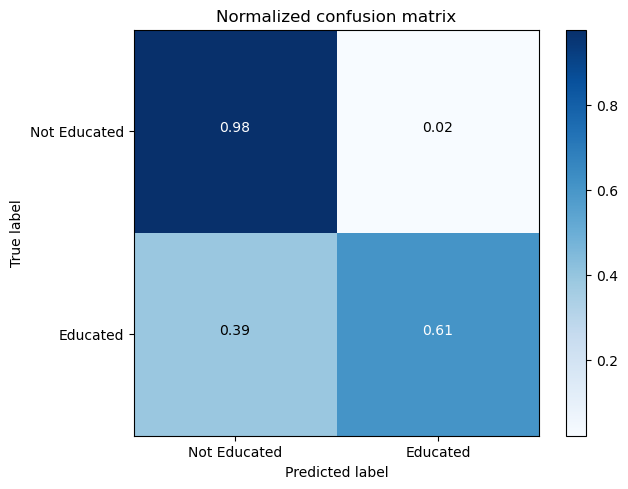

In [39]:
#predictions
bestPipeline_35 = model_35.bestModel
pipe_35 = bestPipeline_35.stages[1]
predictions_35 = bestPipeline_35.transform(cached_test)
classificationMetrics(predictions_35,bcm)

#Visualize Metrics
cnf_matrix_35 = createLabelsCM(predictions_35)
plot_confusion_matrix(cnf_matrix_35, classes=['Not Educated','Educated'], normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [40]:
avgMetricsGrid_35 = model_35.avgMetrics
print(avgMetricsGrid_35)
list(zip(model_35.getEstimatorParamMaps()))

[0.8897782021559708, 0.8917646270705336]


[({Param(parent='RandomForestClassifier_a5b238ab888a', name='numTrees', doc='Number of trees to train (>= 1).'): 30},),
 ({Param(parent='RandomForestClassifier_a5b238ab888a', name='numTrees', doc='Number of trees to train (>= 1).'): 50},)]

### Checking Feature Importance to improve the model by removing features which are not important

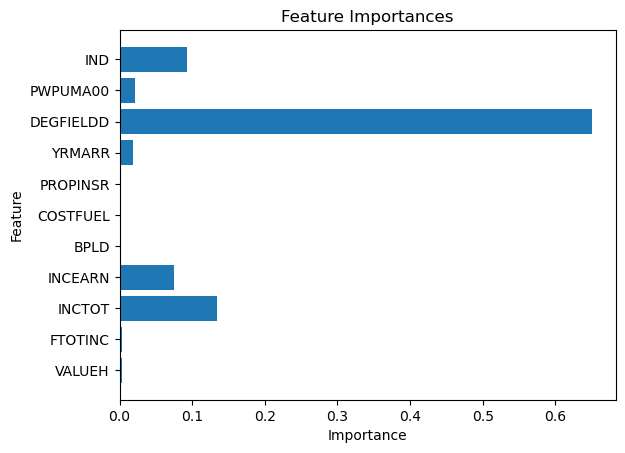

In [41]:
bestModel = bestPipeline_35.stages[2]
importances = bestModel.featureImportances
x_values = list(range(len(importances)))
selected_cols_imp=[cols for cols in keep_pca if cols not in['label','MULTYEAR']]
plt.barh(x_values,importances);
plt.yticks(x_values,selected_cols_imp, rotation=0);
plt.ylabel('Feature');
plt.xlabel('Importance');
plt.title('Feature Importances');
plt.show();

In [ ]:
#Identified important features
'''
keep_imp = ['INCTOT','INCEARN','DEGFIELDD','label','MULTYEAR']

#create sample dataframe
sampled_imp = createSampleData(df,keep_imp,0.1)

#split data
cached_tr_imp, cached_test_imp = splitData(sampled_imp,split_ratio,seed)

#preProcessTrain data and fit
model_imp = preProcessTrainFit(cached_tr_imp,rf,None,paramGrid,bcm,numFolds,seed)

#preprocess testdata
scaled_test_imp = preProcessTest(cached_test_imp)

#predictions
bestPipeline_imp = model_imp.bestModel
pipe_imp = bestPipeline_imp.stages[1]
predictions_imp = bestPipeline_imp.transform(cached_test_imp)
classificationMetrics(predictions_imp,bcm)

#Visualize Metrics
cnf_matrix_imp = createLabelsCM(predictions_imp)
plot_confusion_matrix(cnf_matrix_imp, classes=['Not Educated','Educated'], normalize=True,
                      title='Normalized confusion matrix')
plt.show()
'''

In [ ]:
'''
avgMetricsGrid_imp = model_imp.avgMetrics
print(avgMetricsGrid_imp)
list(zip(model_imp.getEstimatorParamMaps()))
'''

In [32]:
#References
#https://towardsdatascience.com/pre-process-data-with-pipeline-to-prevent-data-leakage-during-cross-validation-e3442cca7fdc
#https://awesomeopensource.com/project/adornes/spark_python_ml_examples
#https://spark.apache.org/docs/latest/ml-tuning.html
#https://sparkbyexamples.com/pyspark/pyspark-rename-dataframe-column/
#https://spark.apache.org/docs/latest/ml-classification-regression.html#random-forest-classifier
#https://people.stat.sc.edu/haigang/sparkCaseStudy.html